# Import

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import copy
import torch
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.grace_module import GraceLitModule
from src.models.components.simple_dense_net import SimpleDenseNet

# Load CSV

In [2]:
data_dir = "structured"
csv_file = os.path.join(os.getcwd(),"..","data", data_dir, "all_concat.csv")
df = pd.read_csv(csv_file)
print('Total:',len(df))
df.head()

Total: 222750


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,cmd_theta_right_eye_pan,cmd_theta_eyes_tilt,state_theta_lower_neck_pan,state_theta_left_lower_neck_tilt,state_theta_right_lower_neck_tilt,state_theta_left_upper_neck_tilt,state_theta_right_upper_neck_tilt,state_theta_left_eye_pan,state_theta_right_eye_pan,state_theta_eyes_tilt
0,-0.873669,-0.334702,0.738088,-1.166921,-0.352033,0.738508,-35,-10,-10,-14,-14,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-14.150391,-14.150391,19.951172
1,-0.821681,-0.331576,0.738000,-0.997318,-0.340332,0.738221,-35,-10,-10,-12,-12,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-12.216797,-12.128906,19.951172
2,-0.731501,-0.324165,0.738176,-0.868484,-0.332085,0.738360,-35,-10,-10,-10,-10,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-9.931641,-9.931641,19.951172
3,-0.672994,-0.320809,0.737795,-0.776648,-0.327031,0.737932,-35,-10,-10,-8,-8,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-8.261719,-8.085938,19.951172
4,-0.613507,-0.317492,0.737656,-0.690487,-0.321762,0.737752,-35,-10,-10,-6,-6,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-6.416016,-6.064453,19.951172


In [3]:
# Filtered df
temp_df = df[~df.isin([-100.0]).any(axis=1)]
valid_df = temp_df[~temp_df.isin([-180.17578125]).any(axis=1)]
valid_df = valid_df.reset_index(drop=True)
print('Valid:',len(valid_df))
print('Removed:', len(df)-len(valid_df))
valid_df.head()

Valid: 212517
Removed: 10233


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,cmd_theta_right_eye_pan,cmd_theta_eyes_tilt,state_theta_lower_neck_pan,state_theta_left_lower_neck_tilt,state_theta_right_lower_neck_tilt,state_theta_left_upper_neck_tilt,state_theta_right_upper_neck_tilt,state_theta_left_eye_pan,state_theta_right_eye_pan,state_theta_eyes_tilt
0,-0.873669,-0.334702,0.738088,-1.166921,-0.352033,0.738508,-35,-10,-10,-14,-14,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-14.150391,-14.150391,19.951172
1,-0.821681,-0.331576,0.738000,-0.997318,-0.340332,0.738221,-35,-10,-10,-12,-12,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-12.216797,-12.128906,19.951172
2,-0.731501,-0.324165,0.738176,-0.868484,-0.332085,0.738360,-35,-10,-10,-10,-10,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-9.931641,-9.931641,19.951172
3,-0.672994,-0.320809,0.737795,-0.776648,-0.327031,0.737932,-35,-10,-10,-8,-8,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-8.261719,-8.085938,19.951172
4,-0.613507,-0.317492,0.737656,-0.690487,-0.321762,0.737752,-35,-10,-10,-6,-6,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-6.416016,-6.064453,19.951172


In [4]:
# X_c_l
lower_bound = -1.25
upper_bound = 1.25
valid_df = valid_df[(valid_df['x_c_l'] >= lower_bound) & (valid_df['x_c_l'] <= upper_bound)]
print('Valid:',len(valid_df))

Valid: 212293


In [5]:
# X_c_r
lower_bound = -1.25
upper_bound = 1.25
valid_df = valid_df[(valid_df['x_c_r'] >= lower_bound) & (valid_df['x_c_r'] <= upper_bound)]
print('Valid:',len(valid_df))

Valid: 210215


In [6]:
# Y_c_l
lower_bound = -1.0
upper_bound = 0.5
valid_df = valid_df[(valid_df['y_c_l'] >= lower_bound) & (valid_df['y_c_l'] <= upper_bound)]
print('Valid:',len(valid_df))

Valid: 210028


In [7]:
# Y_c_r
lower_bound = -1.25
upper_bound = 0.5
valid_df = valid_df[(valid_df['y_c_r'] >= lower_bound) & (valid_df['y_c_r'] <= upper_bound)]
print('Valid:',len(valid_df))

Valid: 209731


In [8]:
# Filtered df
filtered_df = valid_df.reset_index(drop=True)
print("Final:",len(filtered_df))
print("Removed:",len(df)-len(filtered_df))
filtered_df.head()

Final: 209731
Removed: 13019


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,cmd_theta_right_eye_pan,cmd_theta_eyes_tilt,state_theta_lower_neck_pan,state_theta_left_lower_neck_tilt,state_theta_right_lower_neck_tilt,state_theta_left_upper_neck_tilt,state_theta_right_upper_neck_tilt,state_theta_left_eye_pan,state_theta_right_eye_pan,state_theta_eyes_tilt
0,-0.873669,-0.334702,0.738088,-1.166921,-0.352033,0.738508,-35,-10,-10,-14,-14,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-14.150391,-14.150391,19.951172
1,-0.821681,-0.331576,0.738000,-0.997318,-0.340332,0.738221,-35,-10,-10,-12,-12,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-12.216797,-12.128906,19.951172
2,-0.731501,-0.324165,0.738176,-0.868484,-0.332085,0.738360,-35,-10,-10,-10,-10,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-9.931641,-9.931641,19.951172
3,-0.672994,-0.320809,0.737795,-0.776648,-0.327031,0.737932,-35,-10,-10,-8,-8,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-8.261719,-8.085938,19.951172
4,-0.613507,-0.317492,0.737656,-0.690487,-0.321762,0.737752,-35,-10,-10,-6,-6,20,-34.365234,-9.228516,9.404297,-10.107422,9.84375,-6.416016,-6.064453,19.951172


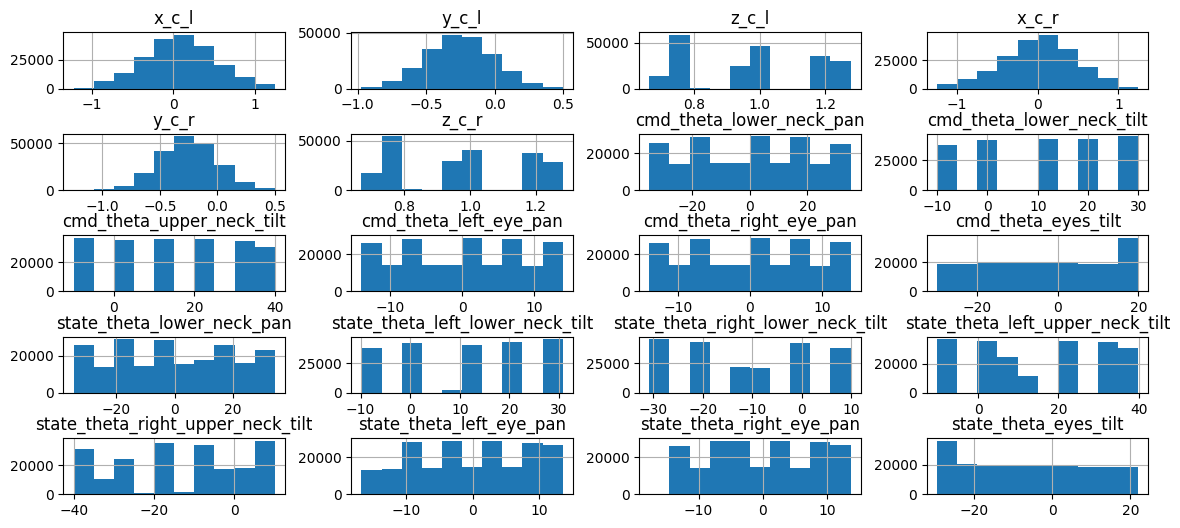

In [9]:
filtered_df.hist(figsize=(14,6))
# Adjust spacing
plt.subplots_adjust(hspace=0.8, wspace=0.3)

# Saving the Final CSV

In [10]:
data_dir = 'final'
filepath = os.path.join(os.getcwd(),"..","data", data_dir, "240909_grace_dataset.csv")
filtered_df.to_csv(filepath, index=False)
print('Saved to:', filepath)

Saved to: /home/jaynieles/dev/grace_dl/notebooks/../data/final/240909_grace_dataset.csv
